<a href="https://colab.research.google.com/github/geoworldlook/F1_predict_model/blob/prediction_2024/create_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00


# Neural Network Model F1

This documentation explains the steps involved in building, training, and evaluating a neural network model for predicting Formula 1 lap times. The model utilizes LSTM layers for time series forecasting based on training and race data for different drivers. The following sections cover the key components, functions, and processes.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import kerastuner as kt
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.losses import Huber


<ipython-input-2-93ba6c01e819>:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt



## Data Loading

Here, the script loads training and race data for each driver in the `driver_list`. The data files are stored in CSV format and are specific to each driver. The `driver_id` column is removed since it's not necessary for model training.

- `X_train_data`: Features for the training set.
- `y_train_data`: Target variable (lap time in seconds) for the training set.
- `X_race_data`: Features for the race set.
- `y_race_data`: Target variable (lap time in seconds) for the race set.




### Explanation of Key Functions

1. **create_sequences**:
   - This function converts data into sequential form for LSTM models.
   - Input: Array of data and sequence length (`seq_length`).
   - Output: Array of sequences used for training.

2. **build_model**:
   - This function builds and compiles an LSTM model.
   - Input: Hyperparameters (`hp`) such as the number of units and layers.
   - Output: Compiled Keras model ready for training.

3. **plot_training_history**:
   - This function plots the training and validation loss curves over epochs.
   - Input: Training history object from the model fit.
   - Output: Visualized training and validation loss over time.

4. **plot_weight_importance**:
   - This function visualizes the importance of different features based on the LSTM model's learned weights.
   - Input: Model weights, feature names, and driver name.
   - Output: Bar plot of feature importance.


## Sequence Creation Function

The `create_sequences` function generates sequences of data for time series forecasting. It slices the dataset into overlapping sequences of length `seq_length`, which is a hyperparameter to be tuned.


In [ ]:
def create_sequences(data, seq_length):
    """
    Converts data into sequences for LSTM models.

    Parameters:
    data (array-like): The input data to be converted into sequences.
    seq_length (int): The length of each sequence.

    Returns:
    np.array: The data converted into sequences.
    """
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)


## Model Building Function

The `build_model` function defines the architecture of the LSTM neural network model. The function uses `keras-tuner` to optimize hyperparameters, such as:
- Number of LSTM layers (`num_layers`)
- Number of units in each LSTM layer (`units`)
- Activation functions (`activation`, `recurrent_activation`)
- Optimizer type (`adam`, `rmsprop`, `sgd`)

The model is compiled with the Huber loss function and evaluation metrics like mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE).


In [ ]:
def build_model(hp):
    """
    Build and compile a LSTM model with hyperparameter tuning.

    Args:
        hp (kt.HyperParameters): The hyperparameters to optimize.

    Returns:
        tf.keras.Model: The compiled LSTM model.
    """
    # Define a Sequential model
    model = tf.keras.Sequential()

    # Define the sequence length as a hyperparameter to vary between 2 and 6
    seq_length = hp.Int('seq_length', min_value=2, max_value=6, step=1)

    # Create input sequences from training data based on the chosen sequence length
    X_train_seq = create_sequences(X_train_data, seq_length)
    y_train_seq = create_sequences(y_train_data.values, seq_length)

    # Split the sequences into training and validation sets (80% training, 20% validation)
    X_train, X_val, y_train, y_val = train_test_split(X_train_seq, y_train_seq, test_size=0.2, random_state=42)

    # Define the activation function for the LSTM layers as a hyperparameter (can be 'relu', 'tanh', or 'sigmoid')
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Define the recurrent activation function for the LSTM layers as a hyperparameter (either 'sigmoid' or 'tanh')
    recurrent_activation = hp.Choice('recurrent_activation', ['sigmoid', 'tanh'])

    # Loop to add LSTM layers to the model, with a variable number of layers (between 1 and 3)
    for i in range(hp.Int('num_layers', 1, 3)):

        # Add an LSTM layer to the model
        model.add(tf.keras.layers.LSTM(
            # Define the number of units in the LSTM layer as a hyperparameter (between 32 and 256)
            units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),

            # Use the chosen activation function
            activation=activation,

            # Use the chosen recurrent activation function
            recurrent_activation=recurrent_activation,

            # Determine if the layer returns sequences (True for all but the last LSTM layer)
            return_sequences=(i < hp.Int('num_layers', 1, 3) - 1),

            # Define the dropout rate for this LSTM layer as a hyperparameter (between 0.0 and 0.5)
            dropout=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1),

            # Define the recurrent dropout rate as a hyperparameter (between 0.0 and 0.5)
            recurrent_dropout=hp.Float('recurrent_dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1),

            # Apply L2 regularization to the kernel weights, with the regularization value as a hyperparameter
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('kernel_regularizer_' + str(i), min_value=1e-5, max_value=1e-2, sampling='log')),

            # Apply L2 regularization to the bias weights, with the regularization value as a hyperparameter
            bias_regularizer=tf.keras.regularizers.l2(hp.Float('bias_regularizer_' + str(i), min_value=1e-5, max_value=1e-2, sampling='log'))
        ))

    # Add a Dense layer with a variable number of units (between 32 and 256), using 'relu' activation
    model.add(tf.keras.layers.Dense(
        hp.Int('dense_units', min_value=32, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('kernel_regularizer_dense', min_value=1e-5, max_value=1e-2, sampling='log')),
        bias_regularizer=tf.keras.regularizers.l2(hp.Float('bias_regularizer_dense', min_value=1e-5, max_value=1e-2, sampling='log'))
    ))

    # Add the final output layer with 1 unit (for regression prediction)
    model.add(tf.keras.layers.Dense(1))

    # Choose the optimizer as a hyperparameter (options: 'adam', 'rmsprop', 'sgd')
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])

    # Configure the optimizer with a learning rate hyperparameter (different options based on optimizer)
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    else:
        optimizer = tf.keras.optimizers.SGD(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))

    # Compile the model with Huber loss (delta as a hyperparameter) and standard regression metrics
    model.compile(
        optimizer=optimizer,
        loss=Huber(delta=hp.Float('delta', min_value=0.1, max_value=2.0, step=0.1)),
        metrics=['mae', MeanSquaredError(), RootMeanSquaredError(), MeanAbsolutePercentageError()]
    )

    # Return the constructed model
    return model

In [ ]:
def plot_weight_importance(weights, feature_names, driver):
            """
            Function to visualize the importance of features based on the absolute value of the weights.

            Args:
                weights: The weight matrix from the trained model.
                feature_names: Names of the features corresponding to the weight matrix.
                driver: Name of the driver for the title of the plot.
            """
            # Take the absolute value of the weights and average across neurons
            avg_weights = np.mean(np.abs(weights), axis=1)

            # Sort the features based on the average weight
            sorted_idx = np.argsort(avg_weights)[::-1]

            # Create a horizontal bar plot
            plt.figure(figsize=(12, 8))
            plt.barh(range(len(feature_names)), avg_weights[sorted_idx], align='center', color='skyblue')
            plt.yticks(range(len(feature_names)), np.array(feature_names)[sorted_idx])
            plt.xlabel('Average Absolute Weight')
            plt.ylabel('Features')
            plt.title(f'Feature Importance (Weights) for {driver}')

            # Add a threshold for important features (optional)
            threshold = 0.01  # You can adjust this threshold
            plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')
            plt.legend()

            plt.tight_layout()
            plt.show()



# Initializing Parameters and Driver List

Here, we initialize empty lists to store training and race histories (`all_histories_train`, `all_histories_race`) and the weights of the models (`wage_weights`). The list `driver_list` contains the names of Formula 1 drivers for whom the model will be built.


In [ ]:
all_histories_train = []
all_histories_race = []
wage_weights = []

model_parametr_objective = ['mean_squared_error']
driver_list = ['VER', 'NOR', 'PER', 'LEC', 'PIA', 'RUS', 'HAM']#,'SAI']


## Model Training and Evaluation Loop for Multiple Drivers

This section iterates through a list of drivers (`driver_list`). For each driver, the following steps are performed:

1. **Data Loading**: The training and race data for each driver are loaded from CSV files.
2. **Data Preparation**: Sequences for training the model are created.
3. **Model Building**: A neural network (LSTM) model is built and trained for each driver.
4. **Training the Model**: The model is trained on the training data.
5. **Evaluating the Model**: Model performance is evaluated on the race data.
6. **Results Visualization**: The training history and feature importance are visualized.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.losses import Huber
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsolutePercentageError
import keras_tuner as kt

# Iterate over model objectives and drivers
for type_objective in model_parametr_objective:
    for driver in driver_list:

        # Load the training and race data for each driver
        train_data = pd.read_csv(f"/content/drive/MyDrive/F1_MODEL/with_points/2022_2024/train_data_scaled_points_{driver}.csv")
        race_data = pd.read_csv(f"/content/drive/MyDrive/F1_MODEL/with_points/2022_2024/race_data_scaled_points_{driver}.csv")

        # Prepare feature matrices (X) and target vectors (y)
        X_train_data = train_data.drop(['driver_id'], axis=1)
        y_train_data = train_data['LapTime_seconds']
        X_race_data = race_data.drop(['driver_id'], axis=1)
        y_race_data = race_data['LapTime_seconds']

        # Hyperparameter tuning using KerasTuner
        tuner = kt.Hyperband(
            build_model,
            objective=type_objective,
            max_epochs=30,
            factor=3,
            directory=f"/content/drive/MyDrive/F1_MODEL/with_points/models_v3/my_dir_{driver}_{type_objective}_points_huber",
            project_name='f1_lap_time_prediction_points'
        )

        # Set sequence length and create sequences for training
        SEQ_LENGTH = 3
        X_train_seq = create_sequences(X_train_data.values, SEQ_LENGTH)
        y_train_seq = create_sequences(y_train_data.values, SEQ_LENGTH)

        # Search for the best hyperparameters
        tuner.search(X_train_seq, y_train_seq, epochs=30, validation_split=0.2)

        # Retrieve the best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

        # Build the model using the best hyperparameters
        model = tuner.hypermodel.build(best_hps)

        # Train the model on training data
        history_train = model.fit(X_train_seq, y_train_seq, epochs=35, validation_split=0.2, batch_size=32)

        # Create sequences from race data using the best sequence length
        X_race_seq = create_sequences(X_race_data.values, best_hps.get('seq_length'))
        y_race_seq = create_sequences(y_race_data.values, best_hps.get('seq_length'))

        # Fine-tune the model on race data
        history_race = model.fit(X_race_seq, y_race_seq, validation_split=0.2, epochs=20, batch_size=32)

        # Append the training and race histories for analysis
        all_histories_train.append(history_train)
        all_histories_race.append(history_race)

        # Save model weights for future use
        weights = model.get_weights()[0]
        wage_weights.append(weights)

        # Base stats about model
        print(driver)
        print(f"Best seq: {best_hps.get('seq_length')}")
        print(f"Best number of layer LSTM: {best_hps.get('num_layers')}")
        for i in range(best_hps.get('num_layers')):
          print(f"Number of units in Dense {i+1}: {best_hps.get('units_' + str(i))}")
        print(f"Number of units in Dense: {best_hps.get('dense_units')}")
        print(f"Best optimizer: {best_hps.get('optimizer')}")

        model.save(f"/content/drive/MyDrive/F1_MODEL/with_points/2022_2024/model_v3/model_trained_with_best_hyperparams_and_race_data_{driver}_{type_objective}_points_huber.h5")



Reloading Tuner from /content/drive/MyDrive/F1_MODEL/with_points/models_v3/my_dir_VER_mean_squared_error_points_huber/f1_lap_time_prediction_points/tuner0.json
Epoch 1/35
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.9040 - mae: 0.5616 - mean_absolute_percentage_error: 197.7498 - mean_squared_error: 0.5616 - root_mean_squared_error: 0.7427 - val_loss: 0.7857 - val_mae: 0.4448 - val_mean_absolute_percentage_error: 138.3812 - val_mean_squared_error: 0.3954 - val_root_mean_squared_error: 0.6288
Epoch 2/35
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7360 - mae: 0.3772 - mean_absolute_percentage_error: 205.4397 - mean_squared_error: 0.3109 - root_mean_squared_error: 0.5574 - val_loss: 0.7157 - val_mae: 0.4338 - val_mean_absolute_percentage_error: 142.0445 - val_mean_squared_error: 0.3893 - val_root_mean_squared_error: 0.6239
Epoch 3/35
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6719 - mae: 0.3798 - mean_absolute_percentage_error: 184.4818 - mean_squared_error: 0.3115 - root_m

VER
Best seq: 3
Best number of layer LSTM: 1
Number of units in Dense 1: 96
Number of units in Dense: 160
Best optimizer: adam
Reloading Tuner from /content/drive/MyDrive/F1_MODEL/with_points/models_v3/my_dir_NOR_mean_squared_error_points_huber/f1_lap_time_prediction_points/tuner0.json
Epoch 1/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 1.0760 - mae: 0.8905 - mean_absolute_percentage_error: 103.8275 - mean_squared_error: 1.2763 - root_mean_squared_error: 1.1294 - val_loss: 1.0084 - val_mae: 0.9307 - val_mean_absolute_percentage_error: 104.5483 - val_mean_squared_error: 1.2203 - val_root_mean_squared_error: 1.1047
Epoch 2/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.9006 - mae: 0.8223 - mean_absolute_percentage_error: 140.5535 - mean_squared_error: 1.0818 - root_mean_squared_error: 1.0378 - val_loss: 0.7966 - val_mae: 0.7919 - val_mean_absolute_percentage_error: 107.1500 - val_mean_squared_error: 0.8588 - val_root_mean_squared_error: 0.9267
Epoch 3/35
72/72 ━━━━━━━━━━━━━━

NOR
Best seq: 5
Best number of layer LSTM: 1
Number of units in Dense 1: 192
Number of units in Dense: 96
Best optimizer: adam
Reloading Tuner from /content/drive/MyDrive/F1_MODEL/with_points/models_v3/my_dir_PER_mean_squared_error_points_huber/f1_lap_time_prediction_points/tuner0.json
Epoch 1/35
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.2698 - mae: 0.6486 - mean_absolute_percentage_error: 263.8084 - mean_squared_error: 0.7468 - root_mean_squared_error: 0.8555 - val_loss: 0.6584 - val_mae: 0.5172 - val_mean_absolute_percentage_error: 169.1409 - val_mean_squared_error: 0.4980 - val_root_mean_squared_error: 0.7057
Epoch 2/35
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5356 - mae: 0.4638 - mean_absolute_percentage_error: 352.7307 - mean_squared_error: 0.4439 - root_mean_squared_error: 0.6661 - val_loss: 0.3575 - val_mae: 0.5016 - val_mean_absolute_percentage_error: 190.0201 - val_mean_squared_error: 0.4918 - val_root_mean_squared_error: 0.7013
Epoch 3/35
71/71 ━━━━━━━━━━━━━━━

PER
Best seq: 2
Best number of layer LSTM: 1
Number of units in Dense 1: 128
Number of units in Dense: 224
Best optimizer: adam
Reloading Tuner from /content/drive/MyDrive/F1_MODEL/with_points/models_v3/my_dir_LEC_mean_squared_error_points_huber/f1_lap_time_prediction_points/tuner0.json
Epoch 1/35
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.4693 - mae: 0.6705 - mean_absolute_percentage_error: 220.6821 - mean_squared_error: 0.7762 - root_mean_squared_error: 0.8750 - val_loss: 0.3046 - val_mae: 0.5271 - val_mean_absolute_percentage_error: 470.6530 - val_mean_squared_error: 0.4895 - val_root_mean_squared_error: 0.6997
Epoch 2/35
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2545 - mae: 0.4494 - mean_absolute_percentage_error: 282.6429 - mean_squared_error: 0.4048 - root_mean_squared_error: 0.6361 - val_loss: 0.2589 - val_mae: 0.5047 - val_mean_absolute_percentage_error: 411.7491 - val_mean_squared_error: 0.4594 - val_root_mean_squared_error: 0.6778
Epoch 3/35
75/75 ━━━━━━━━━━━━━━

LEC
Best seq: 3
Best number of layer LSTM: 2
Number of units in Dense 1: 64
Number of units in Dense 2: 32
Number of units in Dense: 256
Best optimizer: adam
Reloading Tuner from /content/drive/MyDrive/F1_MODEL/with_points/models_v3/my_dir_PIA_mean_squared_error_points_huber/f1_lap_time_prediction_points/tuner0.json
Epoch 1/35
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.4739 - mae: 0.6307 - mean_absolute_percentage_error: 253.0795 - mean_squared_error: 0.6887 - root_mean_squared_error: 0.8216 - val_loss: 0.2879 - val_mae: 0.4670 - val_mean_absolute_percentage_error: 577.9800 - val_mean_squared_error: 0.4057 - val_root_mean_squared_error: 0.6370
Epoch 2/35
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2839 - mae: 0.4745 - mean_absolute_percentage_error: 279.3264 - mean_squared_error: 0.4216 - root_mean_squared_error: 0.6491 - val_loss: 0.2432 - val_mae: 0.4413 - val_mean_absolute_percentage_error: 617.8382 - val_mean_squared_error: 0.3947 - val_root_mean_squared_error: 0.6282


PIA
Best seq: 3
Best number of layer LSTM: 2
Number of units in Dense 1: 96
Number of units in Dense 2: 224
Number of units in Dense: 96
Best optimizer: adam
Reloading Tuner from /content/drive/MyDrive/F1_MODEL/with_points/models_v3/my_dir_RUS_mean_squared_error_points_huber/f1_lap_time_prediction_points/tuner0.json
Epoch 1/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 2.1128 - mae: 0.7375 - mean_absolute_percentage_error: 247.3714 - mean_squared_error: 0.9242 - root_mean_squared_error: 0.9560 - val_loss: 1.8006 - val_mae: 0.4313 - val_mean_absolute_percentage_error: 130.5305 - val_mean_squared_error: 0.3702 - val_root_mean_squared_error: 0.6085
Epoch 2/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 1.8107 - mae: 0.4755 - mean_absolute_percentage_error: 258.6896 - mean_squared_error: 0.4555 - root_mean_squared_error: 0.6749 - val_loss: 1.6823 - val_mae: 0.4176 - val_mean_absolute_percentage_error: 115.0339 - val_mean_squared_error: 0.3529 - val_root_mean_squared_error: 0.5940

RUS
Best seq: 3
Best number of layer LSTM: 3
Number of units in Dense 1: 224
Number of units in Dense 2: 192
Number of units in Dense 3: 224
Number of units in Dense: 192
Best optimizer: rmsprop
Reloading Tuner from /content/drive/MyDrive/F1_MODEL/with_points/models_v3/my_dir_HAM_mean_squared_error_points_huber/f1_lap_time_prediction_points/tuner0.json
Epoch 1/35
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 1.3339 - mae: 0.7968 - mean_absolute_percentage_error: 147.9321 - mean_squared_error: 1.0158 - root_mean_squared_error: 1.0074 - val_loss: 1.0405 - val_mae: 0.7237 - val_mean_absolute_percentage_error: 155.6915 - val_mean_squared_error: 0.7703 - val_root_mean_squared_error: 0.8777
Epoch 2/35
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8408 - mae: 0.5181 - mean_absolute_percentage_error: 670.1323 - mean_squared_error: 0.4625 - root_mean_squared_error: 0.6791 - val_loss: 0.6604 - val_mae: 0.4608 - val_mean_absolute_percentage_error: 161.8385 - val_mean_squared_error: 0.3865 -

HAM
Best seq: 5
Best number of layer LSTM: 3
Number of units in Dense 1: 32
Number of units in Dense 2: 64
Number of units in Dense 3: 32
Number of units in Dense: 96
Best optimizer: adam
Reloading Tuner from /content/drive/MyDrive/F1_MODEL/with_points/models_v3/my_dir_SAI_mean_squared_error_points_huber/f1_lap_time_prediction_points/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
3                 |2                 |seq_length
sigmoid           |sigmoid           |activation
sigmoid           |sigmoid           |recurrent_activation
1                 |2                 |num_layers
128               |32                |units_0
0.3               |0.1               |dropout_0
0.3               |0.4               |recurrent_dropout_0
0.00015378        |0.00092559        |kernel_regularizer_0
2.1918e-05        |0.0060987         |bias_regularizer_0
96                |64                |dense_units
1.9128e-05        |0.00010849        |kernel_reg

/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/metrics_tracking.py:111: RuntimeWarning: All-NaN axis encountered
  np.nanmin(values) if self.direction == "min" else np.nanmax(values)


RuntimeError: Number of consecutive failures exceeded the limit of 3.


### Explanation of Variables:

- `type_objective`: The objective to be optimized during tuning (e.g., 'mean_squared_error', 'mae').
- `driver`: The driver identifier, used to load specific training and race data for each driver.
- `train_data`: Pandas DataFrame containing the scaled training data for the driver.
- `race_data`: Pandas DataFrame containing the scaled race data for the driver.
- `X_train_data`, `y_train_data`: The training input features and target variable (lap times) for the model.
- `X_race_data`, `y_race_data`: The race input features and target variable (lap times).
- `tuner`: Keras Tuner object, used to search for optimal hyperparameters using Hyperband.
- `SEQ_LENGTH`: The number of time steps used to create sequences for the LSTM input.
- `X_train_seq`, `y_train_seq`: Sequences of input features and target values, generated from the training data.
- `X_race_seq`, `y_race_seq`: Sequences of input features and target values, generated from the race data.
- `best_hps`: The optimal hyperparameters found during the tuning process.
- `history_train`: The training history of the model, used for analysis of training performance.
- `history_race`: The race data history, used for analysis of how the model performs on race data.
- `all_histories_train`, `all_histories_race`: Lists storing training and race histories for each driver.


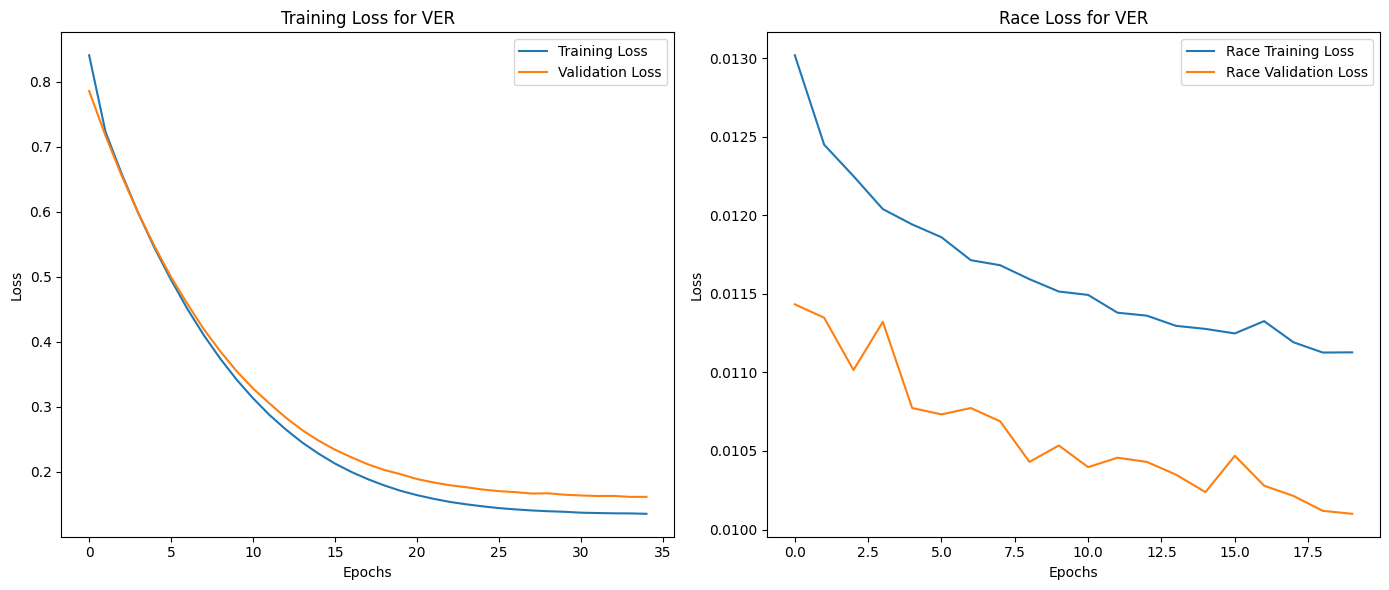

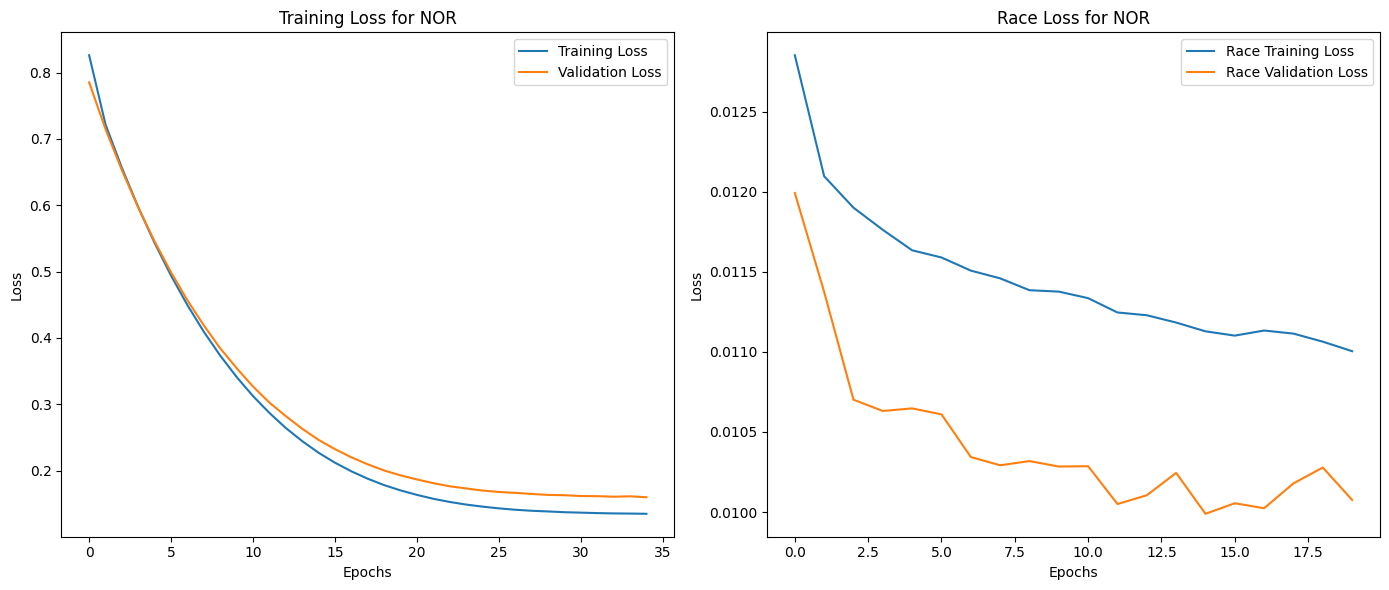

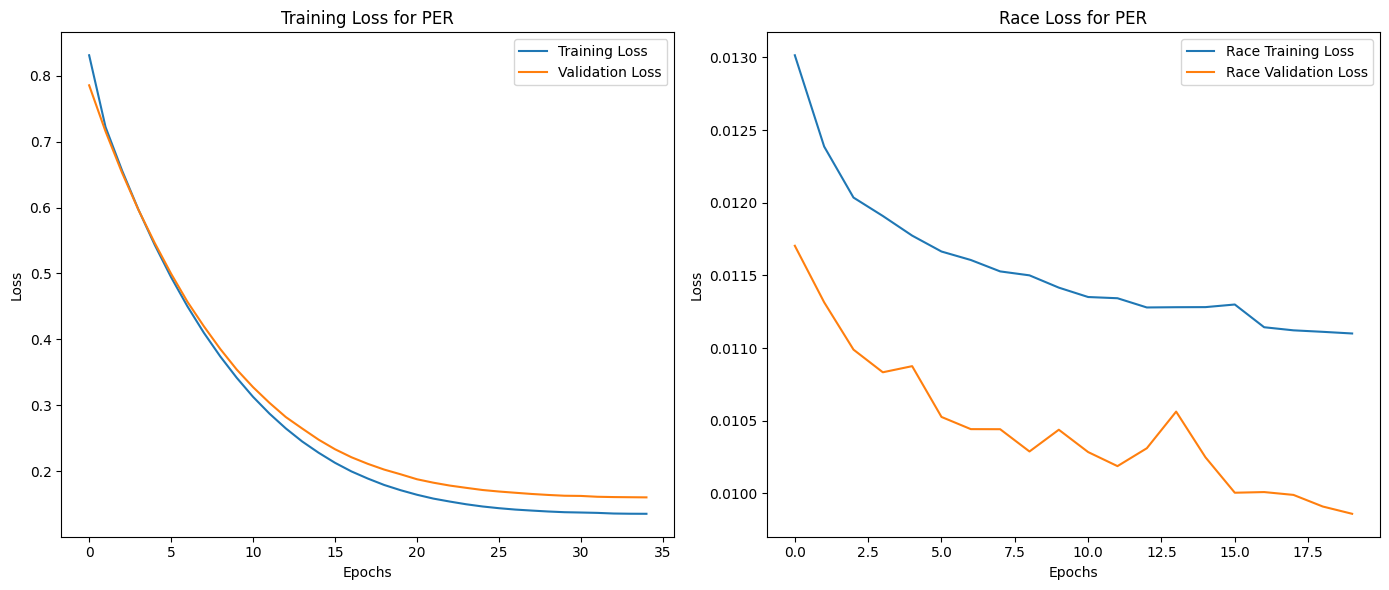

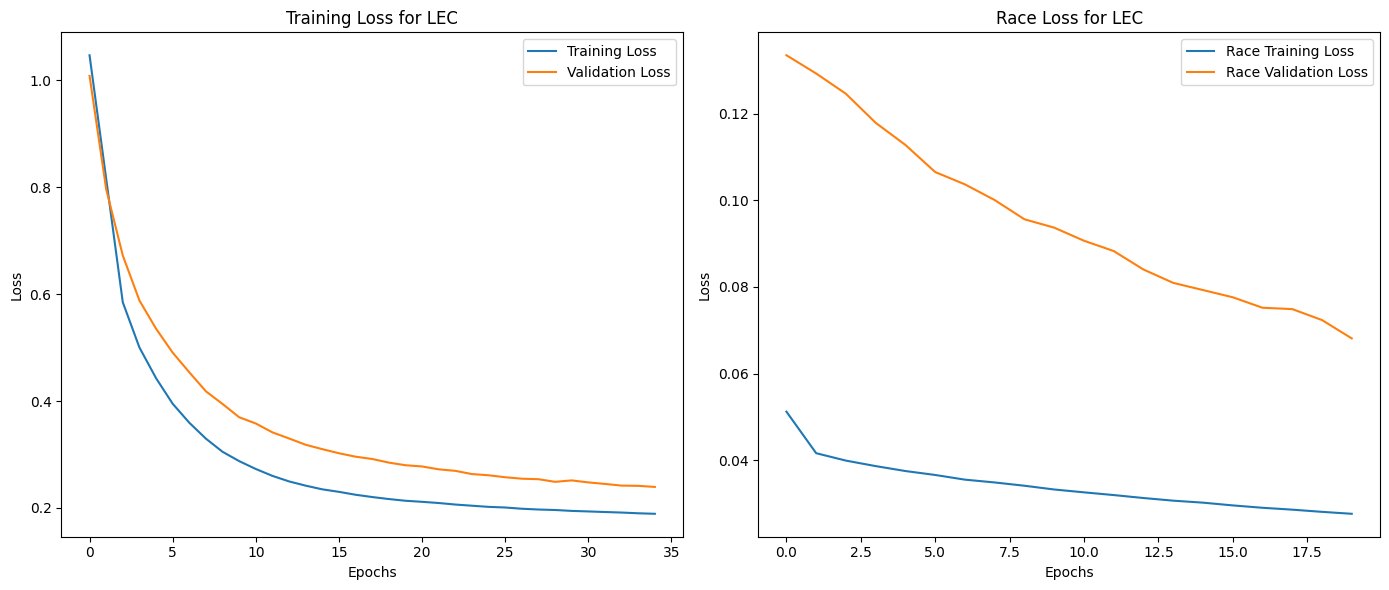

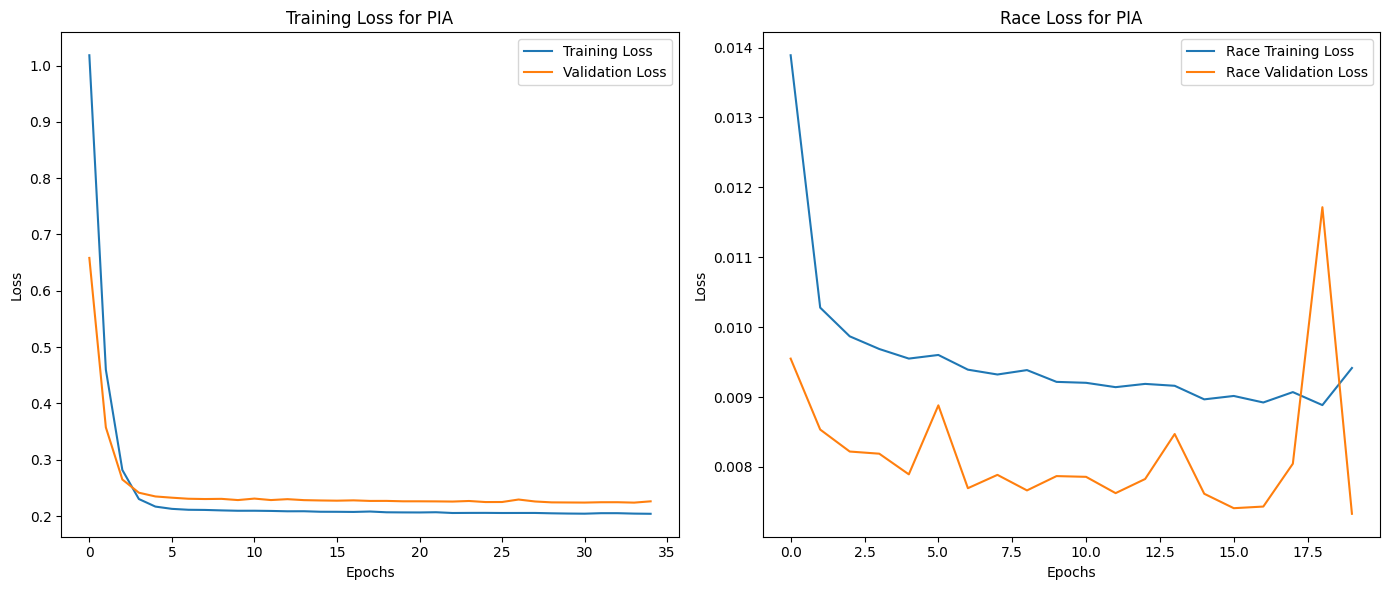

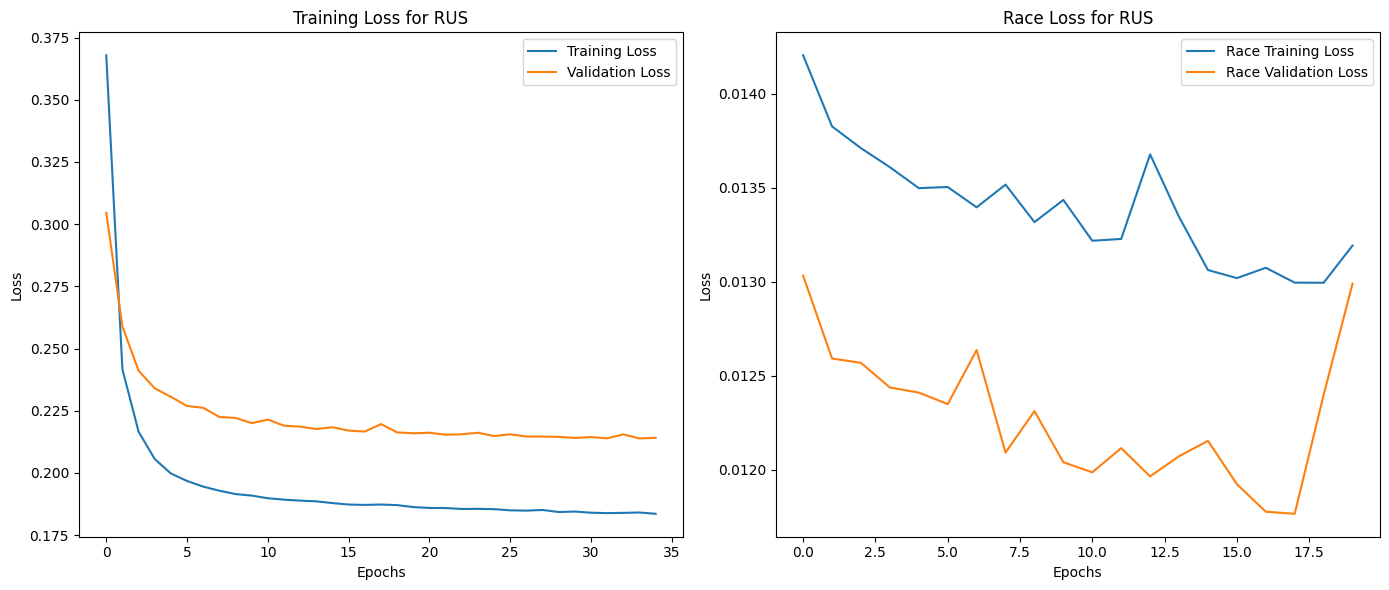

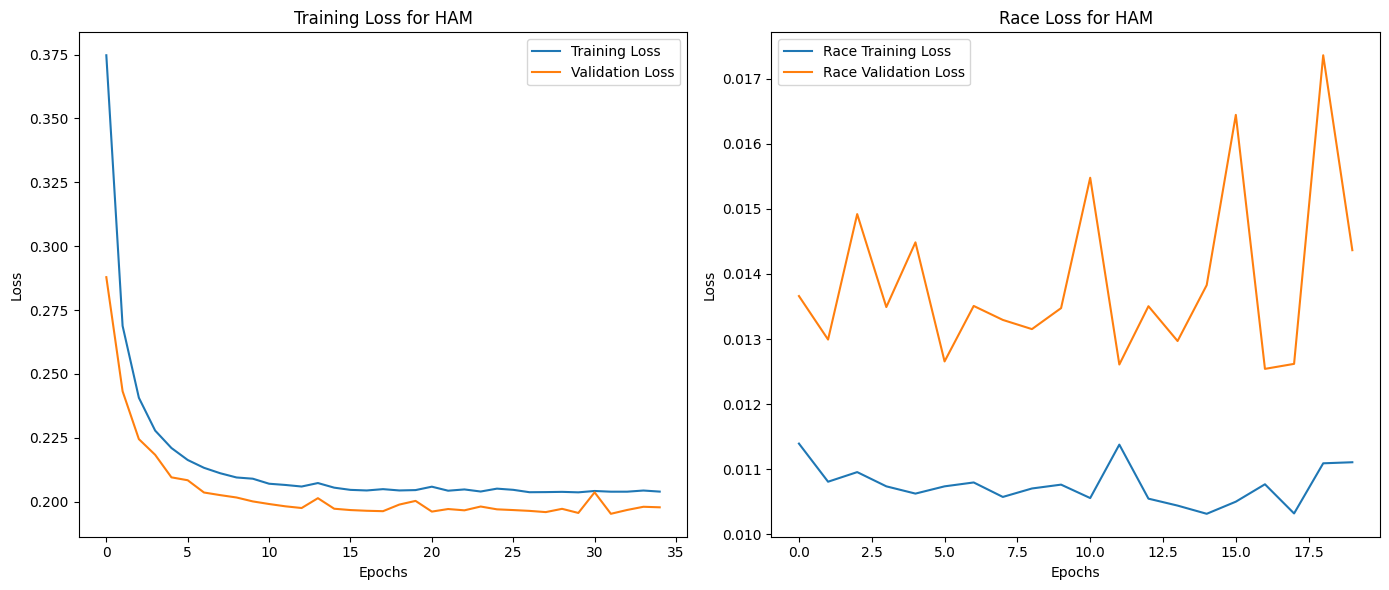

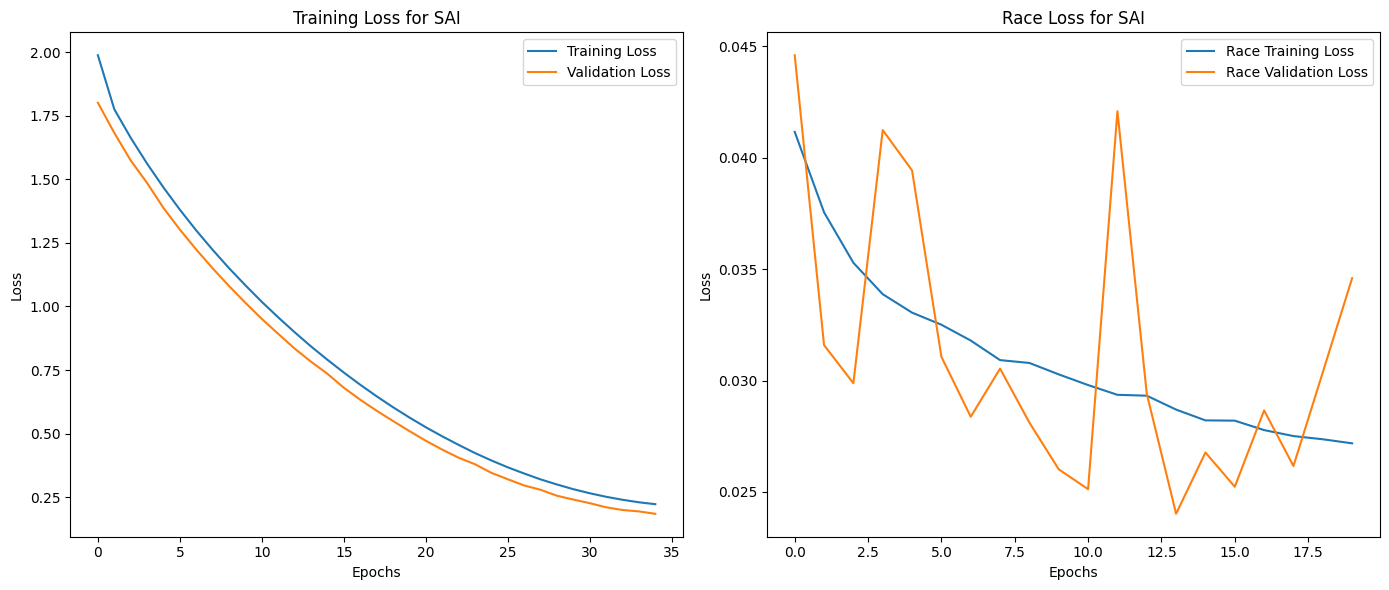

In [ ]:
# Importing the necessary library for plotting
import matplotlib.pyplot as plt

# Function to plot the training and validation loss for each driver
def plot_training_history(history_train, history_race, driver):
    """
    Plots the training and validation loss for both the training and race datasets for a given driver.

    Parameters:
    - history_train (keras.callbacks.History): The training history object, which contains the loss values
      and validation loss values for the training data over the epochs.
    - history_race (keras.callbacks.History): The training history object for race data, which stores the
      loss and validation loss values over the epochs.
    - driver (str): The driver's identifier (e.g., 'VER', 'HAM') used to label the plot.

    This function creates two subplots:
    1. The first subplot shows the training and validation loss for the training data.
    2. The second subplot shows the training and validation loss for the race data.
    """

    # Create a new figure for the plots with a specified size
    plt.figure(figsize=(14, 6))

    # First subplot: Training Loss and Validation Loss for the training data
    plt.subplot(1, 2, 1)
    plt.plot(history_train.history['loss'], label='Training Loss')  # Plot training loss over epochs
    plt.plot(history_train.history['val_loss'], label='Validation Loss')  # Plot validation loss over epochs
    plt.title(f'Training Loss for {driver}')  # Set the title for the training plot
    plt.xlabel('Epochs')  # X-axis label
    plt.ylabel('Loss')  # Y-axis label (loss values)
    plt.legend()  # Add a legend to distinguish between training and validation loss

    # Second subplot: Training Loss and Validation Loss for the race data
    plt.subplot(1, 2, 2)
    plt.plot(history_race.history['loss'], label='Race Training Loss')  # Plot race training loss over epochs
    plt.plot(history_race.history['val_loss'], label='Race Validation Loss')  # Plot race validation loss over epochs
    plt.title(f'Race Loss for {driver}')  # Set the title for the race plot
    plt.xlabel('Epochs')  # X-axis label
    plt.ylabel('Loss')  # Y-axis label (loss values)
    plt.legend()  # Add a legend to distinguish between race training and validation loss

    # Adjust the layout of the plots to avoid overlap
    plt.tight_layout()

    # Display the plots
    plt.show()

# Plot training and validation performance for each driver
for i, driver in enumerate(driver_list):
    """
    Looping through each driver in the driver_list and plotting the training history and race history
    using the plot_training_history function.

    Parameters:
    - i (int): The index of the current driver in the driver_list.
    - driver (str): The driver's identifier (e.g., 'VER', 'HAM').
    - all_histories_train (list): A list of training history objects for each driver.
    - all_histories_race (list): A list of race history objects for each driver.

    For each driver, the function retrieves the corresponding training and race history,
    then calls the plot_training_history function to create the plots.
    """
    plot_training_history(all_histories_train[i], all_histories_race[i], driver)
